## Model building and training

In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import os, sys
# Add the 'scripts' directory to the Python path for module imports
sys.path.append(os.path.abspath(os.path.join('..', 'scripts')))
# Configure logging
from logger import SetupLogger
from data_loader import DataLoader 
from feature_selection import FeatureSelection 
# Import the class
from model_training import ModelTraining
logger = SetupLogger(log_file='../logs/model_training.log').get_logger()

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Disable CUDA


In [3]:
# Create instances
load_fraud = DataLoader('../data/processed_fraud_data.csv', logger=logger)
load_credit = DataLoader('../data/creditcard.csv', logger=logger)
# Load the datasets
fraud_data = load_fraud.load_dataset().set_index('user_id')
credit_data = load_credit.load_dataset()

In [4]:
# Explore the few rows
credit_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
fraud_data.head()

,purchase_value,age,class,purchase_delay,hour_of_day,day_of_week,fraud_rate,user_transaction_frequency,device_transaction_frequency,user_transaction_velocity,source_Direct,source_SEO,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_M
user_id,,,,,,,,,,,,,,,,,
247547,0.549607,-0.363124,0,-0.413800,-1.231124,1.487911,-0.233869,0.0,-0.259874,-0.232945,0.0,1.0,0.0,0.0,0.0,1.0,0.0
220737,-1.197335,0.101168,0,-1.180852,1.229002,-0.505034,-1.259767,0.0,-0.259874,-0.232943,0.0,1.0,0.0,0.0,0.0,0.0,0.0
390400,0.385831,-0.479197,0,-0.936126,1.663142,0.989675,-0.354204,0.0,0.116936,-0.232944,0.0,0.0,0.0,1.0,0.0,0.0,1.0
69592,0.986342,-0.363124,0,0.867086,0.650149,0.989675,-0.354204,0.0,-0.259874,-0.232946,1.0,0.0,0.0,0.0,0.0,0.0,0.0
174987,0.767974,0.449387,0,1.700633,-1.086411,-1.003270,-1.259767,0.0,-0.259874,-0.232946,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Understand the shapes
credit_data.shape, fraud_data.shape

((284807, 31), (129146, 17))

In [7]:
# Check any missing values
print(credit_data.isnull().sum())
print(fraud_data.isnull().sum())

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64
purchase_value                  0
age                             0
class                           0
purchase_delay                  0
hour_of_day                     0
day_of_week                     0
fraud_rate                      0
user_transaction_frequency      0
device_transaction_frequency    0
user_transaction_velocity       0
source_Direct                   0
source_SEO                      0
browser_FireFox                 0
browser_IE                      0
browser_Opera                   0
browser_Safari                  0
sex_M                           0
dtype: int64


**Data Preparation**

- Check class Imbalance

- Feature and Target Separation [‘Class’(creditcard), ‘class’(Fraud_Data)] Train-Test Split

In [8]:
print(credit_data["Class"].value_counts())

Class
0    284315
1       492
Name: count, dtype: int64


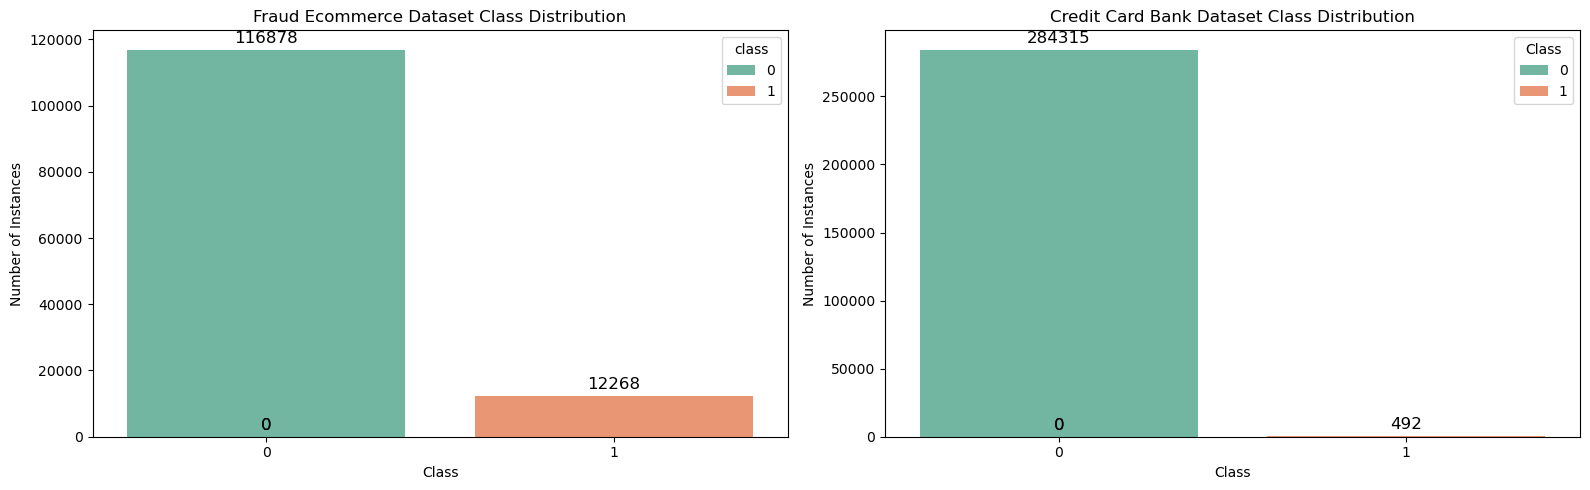

In [9]:
# Function to plot class distribution with total numbers on top of each bar
def plot_class_distribution(class_counts, ax, dataset_name):
    colors = sns.color_palette("Set2", n_colors=len(class_counts))  # Choose a color palette with distinct colors
    sns.barplot(x=class_counts.index, y=class_counts.values, palette=colors, ax=ax, hue=class_counts.index)  # Use the distinct color palette
    ax.set_title(f'{dataset_name} Class Distribution')
    ax.set_ylabel('Number of Instances')
    ax.set_xlabel('Class')
    ax.set_xticks(class_counts.index)

    # Annotate the total number on top of each bar
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='baseline', 
                    fontsize=12, color='black', 
                    xytext=(0, 5), 
                    textcoords='offset points')

# Create a figure with subplots for both datasets
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Check class distribution in fraud dataset
fraud_class_counts = fraud_data['class'].value_counts()  # Ensure 'class' is the correct column name
# Check class distribution in credit card dataset
creditcard_class_counts = credit_data['Class'].value_counts()  # Ensure 'Class' is the correct column name

# Plot for fraud dataset
plot_class_distribution(fraud_class_counts, axes[0], 'Fraud Ecommerce Dataset')

# Plot for credit card dataset
plot_class_distribution(creditcard_class_counts, axes[1], 'Credit Card Bank Dataset')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

**Class Imbalance Summary**

- Fraud Ecommerce Dataset:

    - Class 0 (non-fraudulent): 116,878 instances
    - Class 1 (fraudulent): 12,268 instances
    - Imbalance: Significant, with Class 1 underrepresented.
- Credit Card Bank Dataset:

    - Class 0: 284,315 instances
    - Class 1: 492 instances
    - Imbalance: Extreme, posing serious challenges.
    
**Implications:**

- Biased Models: Models may favor the majority class, resulting in poor detection of fraud.
- Underfitting/Overfitting: Risk of models failing to generalize across classes.
- Evaluation Challenges: Traditional metrics like accuracy can be misleading.
Addressing Class Imbalance:

- Oversampling: Increase minority class instances (e.g., SMOTE).

In [10]:
# Function to apply SMOTE
def apply_smote(X_train, y_train):

    # Apply SMOTE to the training set
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    return X_resampled, y_resampled

In [11]:


_creditcard = FeatureSelection(credit_data, target_column='Class')
_creditcard.train_test_split(test_size=0.2, random_state=42)

# Retrieving the train and test sets
X_train_cc, X_test_cc, y_train_cc, y_test_cc = _creditcard.get_train_test_data()

# apply class balancing technique(SMOTE)

# For Credit Card Bank Dataset
X_credit_resampled, y_credit_resampled = apply_smote(X_train_cc, y_train_cc)
print("\nCredit Card Bank Dataset Class Distribution After SMOTE:")
print(pd.Series(y_credit_resampled).value_counts())

Original dataset class distribution:
Class
0    284315
1       492
Name: count, dtype: int64
Data split into training and testing sets successfully.


c:\Users\Tsegaye\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



Credit Card Bank Dataset Class Distribution After SMOTE:
Class
0    227451
1    227451
Name: count, dtype: int64


In [12]:
_fraud = FeatureSelection(fraud_data, target_column='class')
_fraud.train_test_split(test_size=0.2, random_state=42)

# Retrieving the train and test sets
X_train_fd, X_test_fd, y_train_fd, y_test_fd = _fraud.get_train_test_data()
# Apply class balancing technique(SMOTE)
# For Fraud Ecommerce Dataset
X_fraud_resampled, y_fraud_resampled = apply_smote(X_train_fd, y_train_fd)
# Check the class distribution after SMOTE
print("Fraud Ecommerce Dataset Class Distribution After SMOTE:")
print(pd.Series(y_fraud_resampled).value_counts())

Original dataset class distribution:
class
0    116878
1     12268
Name: count, dtype: int64
Data split into training and testing sets successfully.


c:\Users\Tsegaye\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Fraud Ecommerce Dataset Class Distribution After SMOTE:
class
0    93502
1    93502
Name: count, dtype: int64


**Train and evaluate the model**


Tuning Logistic Regression...
Logistic Regression best parameters: {'classifier__C': 10}
Tuning Decision Tree...
Decision Tree best parameters: {'classifier__max_depth': None}
Tuning Random Forest...
Random Forest best parameters: {'classifier__n_estimators': 100}
Tuning Gradient Boosting...
Gradient Boosting best parameters: {'classifier__learning_rate': 0.1}
Tuning MLP...
MLP best parameters: {'classifier__hidden_layer_sizes': (100,)}


2025/02/12 13:08:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logistic Regression model trained and logged with MLflow


2025/02/12 13:08:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Decision Tree model trained and logged with MLflow


2025/02/12 13:10:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest model trained and logged with MLflow


2025/02/12 13:11:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Gradient Boosting model trained and logged with MLflow


c:\Users\Tsegaye\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
2025/02/12 13:15:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLP model trained and logged with MLflow
808/808 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


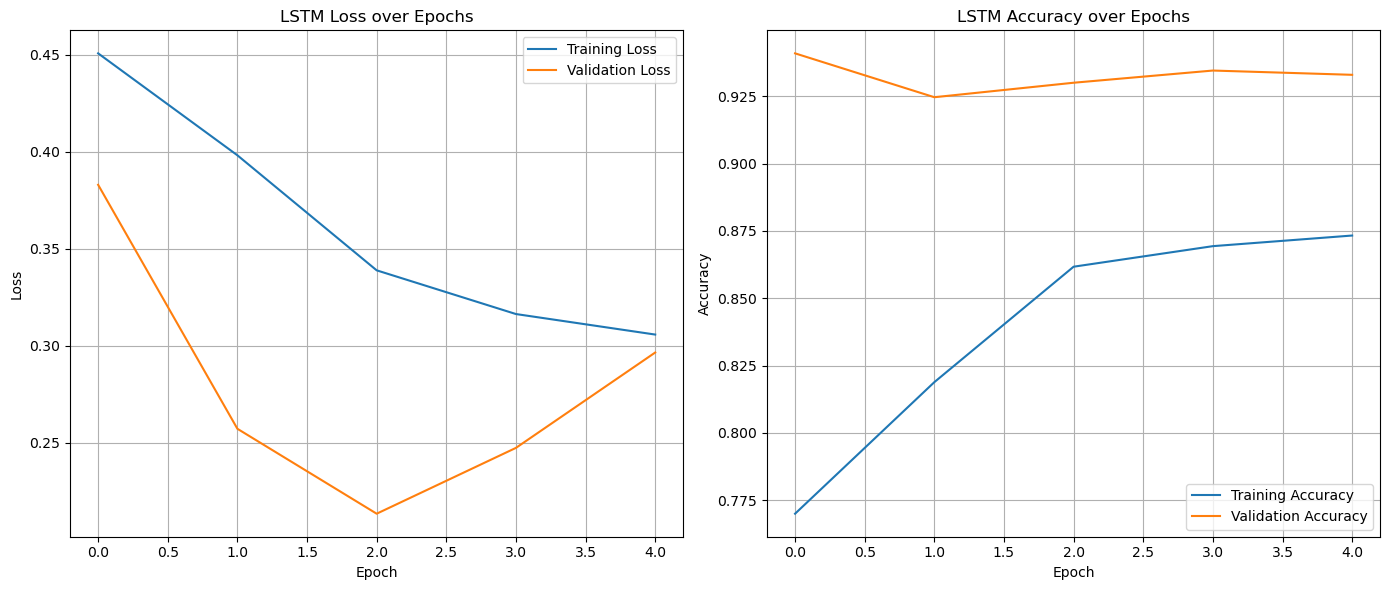

2025/02/12 13:19:42 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/02/12 13:20:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LSTM model trained and logged with MLflow
808/808 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


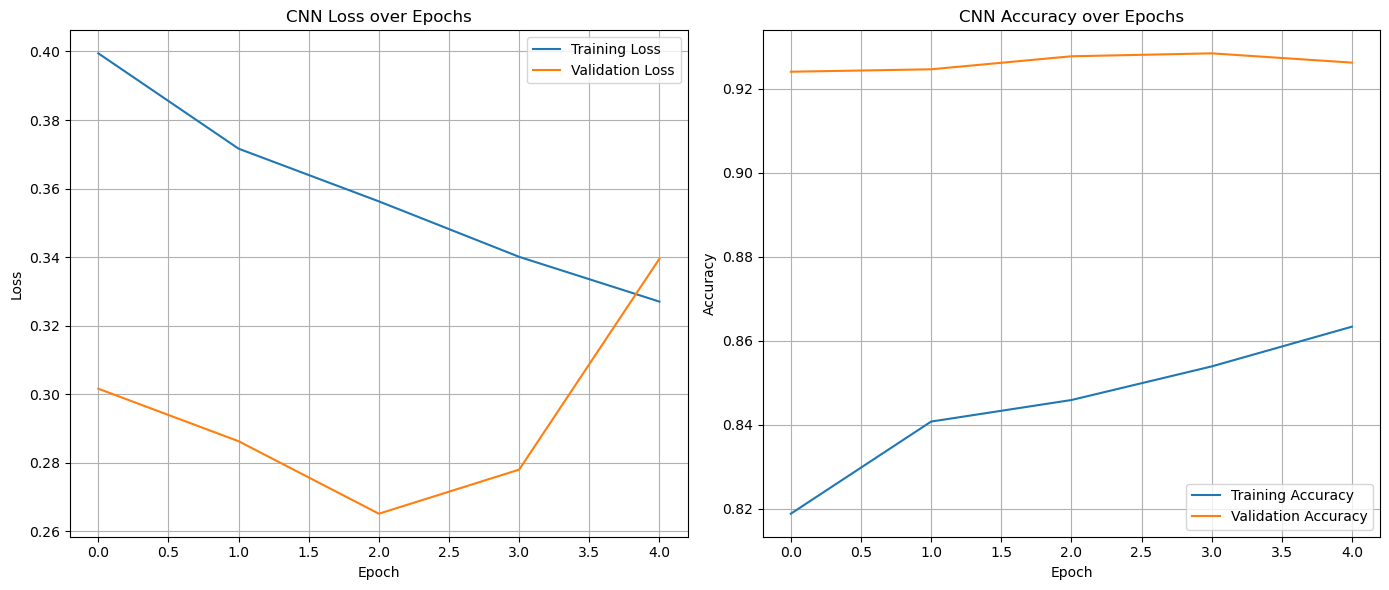

2025/02/12 13:21:38 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/02/12 13:21:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


CNN model trained and logged with MLflow
808/808 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


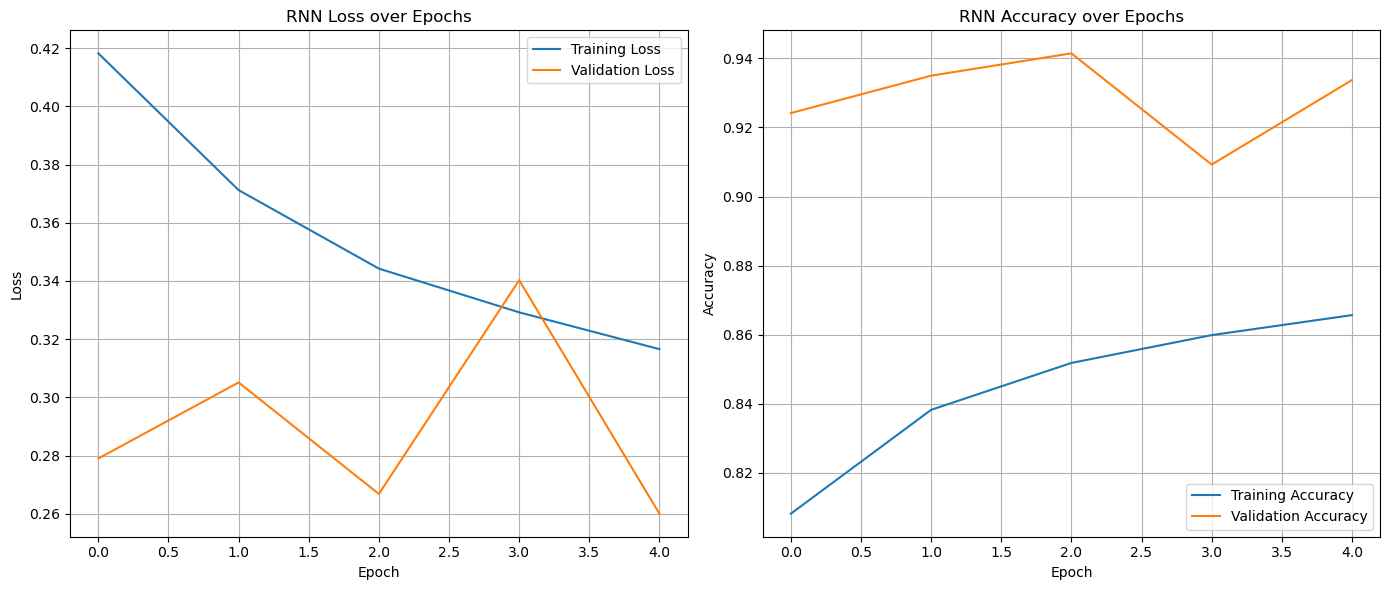

2025/02/12 13:24:23 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/02/12 13:24:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RNN model trained and logged with MLflow
Random Forest best model saved.


In [13]:
# Create instance of the pipeline
model_pipeline = ModelTraining(X_fraud_resampled, X_test_fd, y_fraud_resampled, y_test_fd)

# add models
model_pipeline.add_models()
# Train and evaluate, logging with MLflow
best_model, best_model_name = model_pipeline.train_and_evaluate()
# Save the best model
model_pipeline.save_best_models(best_model, best_model_name, 'fraud')

In [14]:
best_model, best_model_name

(Pipeline(steps=[('scaler', StandardScaler()),
                 ('classifier', RandomForestClassifier())]),
 'Random Forest')

In [15]:
# Get the results 
results_fraud, y_probs_fraud = model_pipeline.get_results()

In [16]:
pd.DataFrame(results_fraud).T

,accuracy,precision,recall,f1_score,roc_auc
Logistic Regression,0.948664,0.833728,0.574165,0.680019,0.843609
Decision Tree,0.908556,0.515797,0.612062,0.559821,0.775872
Random Forest,0.953930,0.923592,0.561532,0.698429,0.839351
Gradient Boosting,0.949826,0.830479,0.592910,0.691869,0.840644
MLP,0.928262,0.616790,0.646699,0.631390,0.828535
LSTM,0.933024,0.639553,0.676039,0.657290,0.837358
CNN,0.926171,0.594735,0.699674,0.642951,0.842324
RNN,0.933720,0.652675,0.646292,0.649468,0.840164
